### Look at Belief State Value CCGP, during Feedback Onset

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
import seaborn as sns

import scipy


In [2]:
PRE_INTERVAL = 1300
POST_INTERVAL = 1500
INTERVAL_SIZE = 100
SMOOTH = 1
EVENT = "FeedbackOnset"
OUTPUT_DIR = "/data/patrick_res/hyak/pseudo"
# path to a dataframe of sessions to analyze
matplotlib.rcParams.update({'font.size': 12})


In [3]:
pairs = pd.read_pickle("/data/patrick_res/sessions/SA/pairs_at_least_3blocks_7sess.pickle")
# pairs = pd.read_pickle("/data/patrick_res/sessions/BL/pairs_at_least_1blocks_3sess.pickle")
pairs = pairs.reset_index(drop=True)

In [4]:
regions = ["temporal", "anterior", None]
conds = ["within_cond", "across_cond", "overall"]

res = []
for region in regions: 
    for cond in conds:  
        for use_next_trial_value in [True, False]: 
            for (feat1, feat2) in pairs.pair.values:
                region_str = "" if region is None else f"_{region}"
                next_trial_str = "_next_trial_value" if use_next_trial_value else ""

                acc = np.load(os.path.join(OUTPUT_DIR, f"SA_ccgp_belief_state_value_{EVENT}_pair_{feat1}_{feat2}{region_str}{next_trial_str}_{cond}_accs.npy"))
                df = pd.DataFrame(acc).reset_index(names=["Time"])
                df["Time"] = (df["Time"] * INTERVAL_SIZE + INTERVAL_SIZE - PRE_INTERVAL) / 1000
                df = df.melt(id_vars="Time", value_vars=list(range(acc.shape[1])), var_name="run", value_name="Accuracy")
                # df["pair"] = feat1, feat2
                df["region"] = region
                df["condition"] = cond
                df["use_next_trial_value"] = use_next_trial_value
                res.append(df)
res = pd.concat(res)

### Overall difference between next trial value and current trial

Text(0.5, 1.0, 'overall difference between next trial value and current trial')

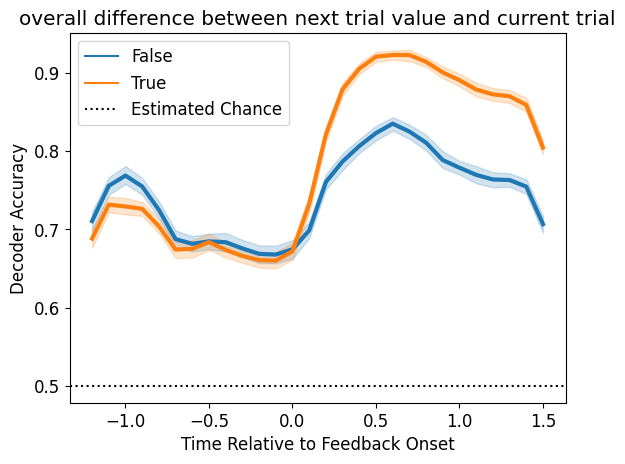

In [5]:
fig, ax = plt.subplots()
overalls = res[(res.condition == "overall") & (res.region.isna())]
sns.lineplot(overalls, x="Time", y="Accuracy", hue="use_next_trial_value", linewidth=3, ax=ax)
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Feedback Onset")
ax.set_title("overall difference between next trial value and current trial")

### Overall, prev vs. next trial

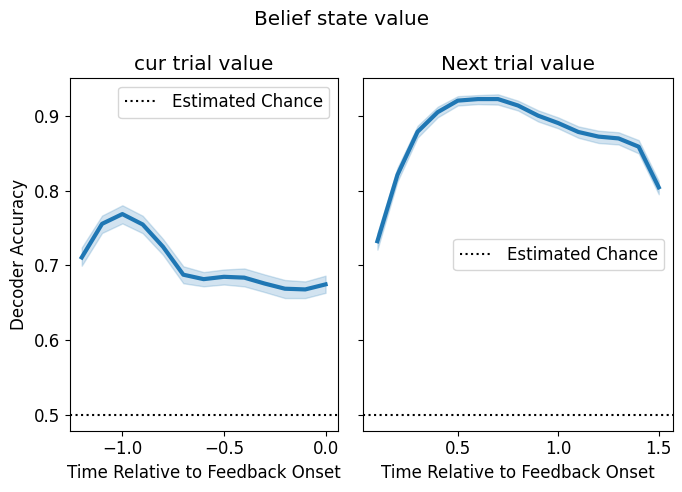

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(7, 5), sharey=True, width_ratios=[13, 15])

ax = axs[0]
overalls = res[(res.condition == "overall") & (~res.use_next_trial_value) & (res.Time <= 0) & (res.region.isna())]
sns.lineplot(overalls, x="Time", y="Accuracy", linewidth=3, ax=ax)
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Feedback Onset")
ax.set_title("cur trial value")

ax = axs[1]
overalls = res[(res.condition == "overall") & (res.use_next_trial_value)& (res.Time > 0) & (res.region.isna())]
sns.lineplot(overalls, x="Time", y="Accuracy", linewidth=3, ax=ax)
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Feedback Onset")
ax.set_title("Next trial value")
fig.suptitle("Belief state value")
fig.tight_layout()


### Temporal vs. Anterior, prev vs. next trial

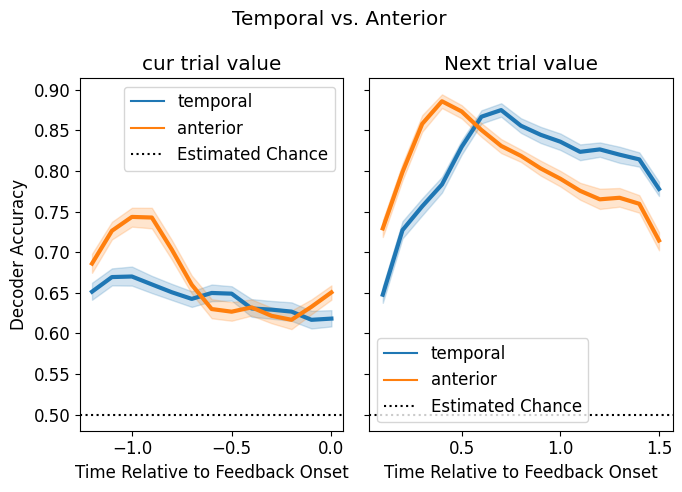

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(7, 5), sharey=True, width_ratios=[13, 15])

ax = axs[0]
overalls = res[(res.condition == "overall") & (~res.use_next_trial_value) & (res.Time <= 0)]
sns.lineplot(overalls, x="Time", y="Accuracy", hue="region", linewidth=3, ax=ax)
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Feedback Onset")
ax.set_title("cur trial value")

ax = axs[1]
overalls = res[(res.condition == "overall") & (res.use_next_trial_value)& (res.Time > 0)]
sns.lineplot(overalls, x="Time", y="Accuracy", hue="region", linewidth=3, ax=ax)
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Feedback Onset")
ax.set_title("Next trial value")
fig.suptitle("Temporal vs. Anterior ")
fig.tight_layout()


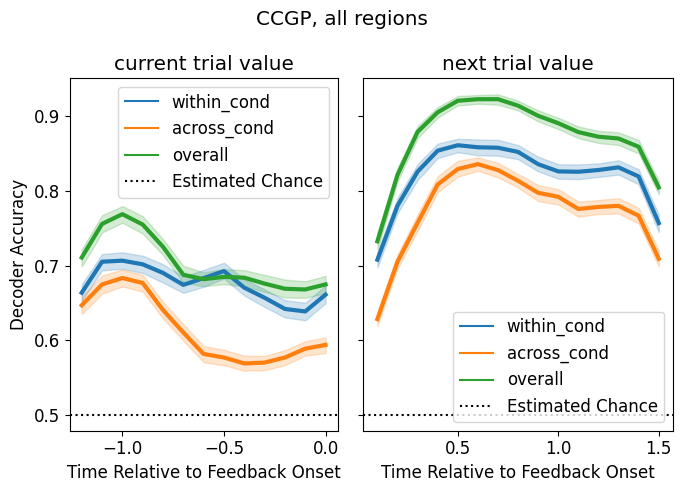

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(7, 5), sharey=True, width_ratios=[13, 15])


ax = axs[0]
overalls = res[(~res.use_next_trial_value) & (res.region.isna()) & (res.Time <= 0)]
sns.lineplot(overalls, x="Time", y="Accuracy", hue="condition", linewidth=3, ax=ax)
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Feedback Onset")
ax.set_title("current trial value")

ax = axs[1]
overalls = res[(res.use_next_trial_value) & (res.region.isna()) & (res.Time > 0)]
sns.lineplot(overalls, x="Time", y="Accuracy", hue="condition", linewidth=3, ax=ax)
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Feedback Onset")
ax.set_title("next trial value")
fig.suptitle("CCGP, all regions")
fig.tight_layout()


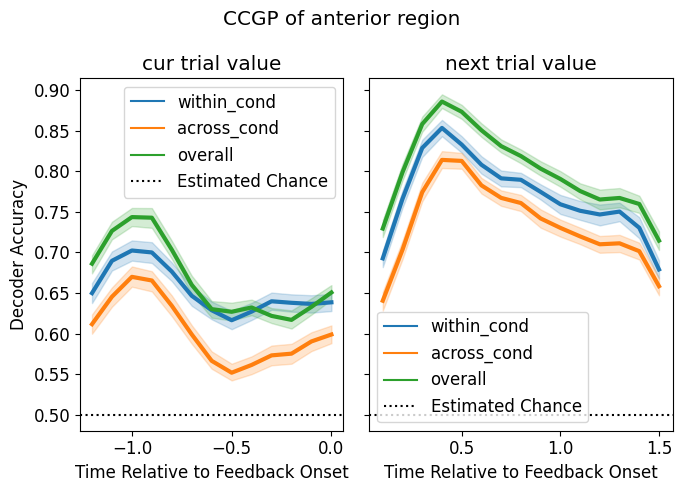

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(7, 5), sharey=True, width_ratios=[13, 15])

ax = axs[0]
overalls = res[(~res.use_next_trial_value) & (res.region == "anterior") & (res.Time <= 0)]
sns.lineplot(overalls, x="Time", y="Accuracy", hue="condition", linewidth=3, ax=ax)
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Feedback Onset")
ax.set_title("cur trial value")

ax = axs[1]
overalls = res[(res.use_next_trial_value) & (res.region == "anterior") & (res.Time > 0)]
sns.lineplot(overalls, x="Time", y="Accuracy", hue="condition", linewidth=3, ax=ax)
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Feedback Onset")
ax.set_title("next trial value")
fig.suptitle("CCGP of anterior region")
fig.tight_layout()




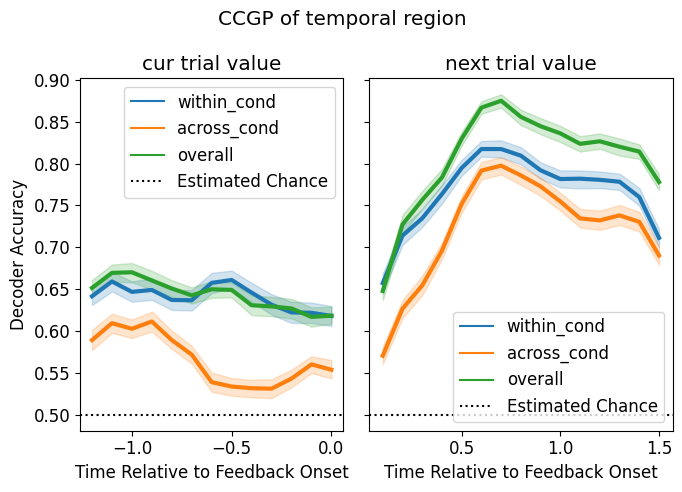

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(7, 5), sharey=True, width_ratios=[13, 15])

ax = axs[0]
overalls = res[(~res.use_next_trial_value) & (res.region == "temporal") & (res.Time <= 0)]
sns.lineplot(overalls, x="Time", y="Accuracy", hue="condition", linewidth=3, ax=ax)
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Feedback Onset")
ax.set_title("cur trial value")

ax = axs[1]
overalls = res[(res.use_next_trial_value) & (res.region == "temporal") & (res.Time > 0)]
sns.lineplot(overalls, x="Time", y="Accuracy", hue="condition", linewidth=3, ax=ax)
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Feedback Onset")
ax.set_title("next trial value")
fig.suptitle("CCGP of temporal region")
fig.tight_layout()

